# Univariate Density Estimation using Models Implemented in Python

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
from pybmix.core.mixing import PythonMixing
from pybmix.core.hierarchy import PythonHierarchy
from pybmix.core.mixture_model import MixtureModel
from pybmix.estimators.density_estimator import DensityEstimator

In [2]:
np.random.seed(2022)

## Generate data as mixture of two Normals

$$
y_i \sim \frac{7}{10} \mathcal N(-3, 1) + \frac{3}{10} \mathcal N(3, 1), \quad i=1, \ldots, 200
$$

In [3]:
def sample_from_mixture_norm(weights, means, sds, n_data):
    n_comp = len(weights)
    clus_alloc = np.random.choice(np.arange(n_comp), p=weights, size=n_data)
    return np.random.normal(loc=means[clus_alloc], scale=sds[clus_alloc])

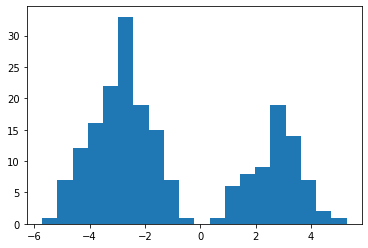

In [4]:
y_norm = sample_from_mixture_norm(
    np.array([0.7, 0.3]), np.array([-3, 3]), np.array([1, 1]), 200)
plt.hist(y_norm, bins=20)
plt.show()

## The statistical model

We assume the following model

\begin{equation}
\begin{aligned}
y_i | \tilde{p} &\sim f(\cdot) = \int_{R \times R^+} \mathcal{Laplace}(\cdot | \mu, \lambda ) \tilde{p}(d\mu, d\lambda) \\
\tilde{p} &\sim DP(\alpha, G_0)
\end{aligned}
\end{equation}

Here, we assume that $\alpha = 5$ and $G_0(d\mu, d\lambda) = \mathcal N(d\mu | \mu_0, \sigma_0^2) \times IG(d\sigma^2 | \nu_0, \psi_0)$, i.e., $G_0$ is a normal-inverse gamma distribution.

"LapNIG_Hierarchy" is implemented in a .py file and here it is passed as argument to the generic PythonHierarchy object.

Below we compare the performances of Laplace-NIG and Normal-NIG models. Please refer to "Univariate Density Estimation via Dirichlet Process Mixture" for the mathematical description of the Normal-NIG model.

In [5]:
mixing = PythonMixing("DP_mixing")
hierarchy_lapnig = PythonHierarchy("LapNIG_Hierarchy")
hierarchy_nnig_ngg = PythonHierarchy("NNIG_Hierarchy_NGG")

In [6]:
mixture_lapnig = MixtureModel(mixing, hierarchy_lapnig)
mixture_nnig_ngg = MixtureModel(mixing, hierarchy_nnig_ngg)

In [7]:
niter = 500
nburn = 100

In [8]:
mixture_lapnig.run_mcmc(y_norm, algorithm="Neal8", niter=niter, nburn=nburn)

Using hierarchy implementation in LapNIG_Hierarchy.py
Using mixing implementation in: DP_mixing.py
Initializing... Done
Running Neal8 algorithm (m=3 aux. blocks) with PythonHier hierarchies, PythonMix mixing...
======>                                                   ] 14% 42.231s[=========>                                                  ] 15% 43.453s[=========>                                                  ] 15% 44.451s[=========>                                                  ] 15% 45.396s[=========>                                                  ] 16% 46.457s[=========>                                                  ] 16% 47.56s[==========>                                                 ] 17% 48.659s[==========>                                                 ] 17% 49.751s[==========>                                                 ] 17% 50.899s[==========>                                                 ] 18% 52.038s[===========>                                        

In [9]:
mixture_nnig_ngg.run_mcmc(y_norm, algorithm="Neal2", niter=niter, nburn=nburn)

Using hierarchy implementation in NNIG_Hierarchy_NGG.py
Initializing... Using mixing implementation in: DP_mixing.py
Done
Running Neal2 algorithm with PythonHier hierarchies, PythonMix mixing...
===========>                                              ] 21% 24.311s[=============>                                              ] 22% 24.762s[=============>                                              ] 22% 25.272s[=============>                                              ] 23% 25.843s[==============>                                             ] 23% 26.271s[==============>                                             ] 23% 26.75s[==============>                                             ] 24% 27.162s[==============>                                             ] 24% 27.571s[===============>                                            ] 25% 27.987s[===============>                                            ] 25% 28.348s[===============>                                            ] 25% 28

In [10]:
grid = np.linspace(-8, 8, 200)
dens_est_lapnig = DensityEstimator(mixture_lapnig)
densities_lapnig = dens_est_lapnig.estimate_density(grid)

[============================================================] 100% 118.829s===================>                                       ] 34% 39.171s[=====================>                                      ] 35% 39.93s[=====================>                                      ] 35% 40.607s[=====================>                                      ] 36% 41.253s[======================>                                     ] 36% 41.773s[======================>                                     ] 37% 42.233s[======================>                                     ] 37% 42.793s[======================>                                     ] 38% 43.301s[=======================>                                    ] 38% 44.299s[=======================>                                    ] 39% 45.001s[========================>                                   ] 40% 45.686s[========================>                                   ] 40% 46.491s[========================>             

In [11]:
dens_est_nnig_ngg = DensityEstimator(mixture_nnig_ngg)
densities_nnig_ngg = dens_est_nnig_ngg.estimate_density(grid)

[============================================================] 100% 78.056s
Done


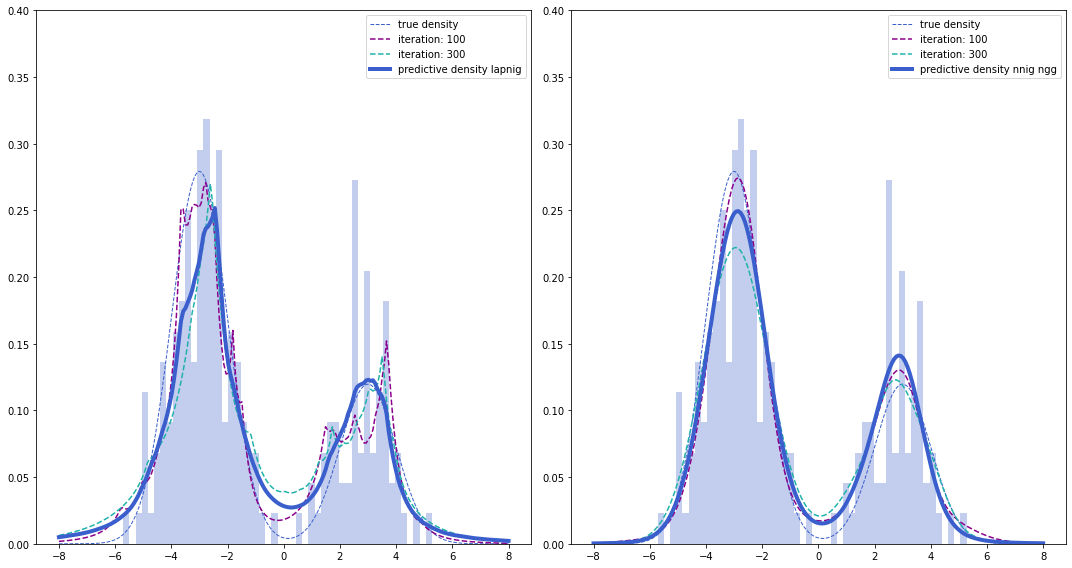

In [12]:
fig, axes = plt.subplots(1,2, figsize=(15,8))

axes[0].set_ylim(0, 0.4)
axes[1].set_ylim(0, 0.4)

axes[0].hist(y_norm, density=True, bins=50, alpha=0.3, color="#3A5FCD")
axes[0].plot(np.linspace(-8, 8, 1000), 0.7*ss.norm.pdf(np.linspace(-8, 8, 1000), -3, 1) + 0.3*ss.norm.pdf(np.linspace(-8, 8, 1000), 3, 1),
             "--", lw=1, color="#3A5FCD", label="true density")
axes[1].hist(y_norm, density=True, bins=50, alpha=0.3, color="#3A5FCD")
axes[1].plot(np.linspace(-8, 8, 1000), 0.7*ss.norm.pdf(np.linspace(-8, 8, 1000), -3, 1) + 0.3*ss.norm.pdf(np.linspace(-8, 8, 1000), 3, 1),
             "--", lw=1, color="#3A5FCD", label="true density")

idxs = [int((niter - nburn) * 0.25), int((niter - nburn) * 0.75)]
colors = ["#8B008B", "#20B2AA"]
for i, idx in enumerate(idxs):
    axes[0].plot(grid, densities_lapnig[idx, :], "--", label="iteration: {0}".format(idx), color = colors[i])
    axes[1].plot(grid, densities_nnig_ngg[idx, :], "--", label="iteration: {0}".format(idx), color = colors[i])
    
axes[0].plot(grid, np.mean(densities_lapnig, axis=0), lw=4, label="predictive density lapnig", color="#3A5FCD")
axes[1].plot(grid, np.mean(densities_nnig_ngg, axis=0), lw=4, label="predictive density nnig ngg", color="#3A5FCD")

axes[0].legend()
axes[1].legend()

axes[0].set_title("LapNIG density estimation on mixture of Normal data")
axes[1].set_title("NNIG density estimation on mixture of Normal data")

plt.tight_layout()
plt.show()

## Generate data as mixture of two Laplace


Let us now repeat the procedure with data sampled from a mixture of Laplace 
$$
y_i \sim \frac{7}{10} \mathcal Laplace(-3, 1) + \frac{3}{10} \mathcal Laplace(3, 1), \quad i=1, \ldots, 200
$$

In [13]:
def sample_from_mixture_lap(weights, means, sds, n_data):
    n_comp = len(weights)
    clus_alloc = np.random.choice(np.arange(n_comp), p=weights, size=n_data)
    return np.random.laplace(loc=means[clus_alloc], scale=sds[clus_alloc])

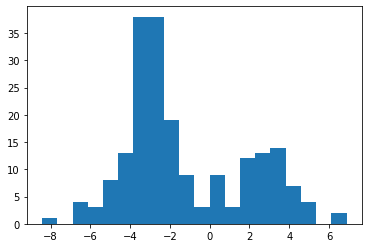

In [14]:
y_lap = sample_from_mixture_lap(
    np.array([0.7, 0.3]), np.array([-3, 3]), np.array([1, 1]), 200)
plt.hist(y_lap, bins=20)
plt.show()

In [15]:
mixture_lapnig_2 = MixtureModel(mixing, hierarchy_lapnig)
mixture_nnig_ngg_2 = MixtureModel(mixing, hierarchy_nnig_ngg)

In [16]:
niter = 500
nburn = 100

In [17]:
mixture_lapnig_2.run_mcmc(y_lap, algorithm="Neal8", niter=niter, nburn=nburn)

Initializing... Using hierarchy implementation in LapNIG_Hierarchy.py
Using mixing implementation in: DP_mixing.py
Done
Running Neal8 algorithm (m=3 aux. blocks) with PythonHier hierarchies, PythonMix mixing...
====>                                                     ] 10% 34.585s[======>                                                     ] 11% 35.647s[=======>                                                    ] 11% 36.73s[=======>                                                    ] 12% 37.82s[=======>                                                    ] 12% 39.005s[=======>                                                    ] 12% 40.323s[========>                                                   ] 13% 41.639s[========>                                                   ] 13% 42.903s[========>                                                   ] 14% 44.011s[========>                                                   ] 14% 45.084s[=========>                                           

In [18]:
mixture_nnig_ngg_2.run_mcmc(y_lap, algorithm="Neal2", niter=niter, nburn=nburn)

Initializing... Using hierarchy implementation in NNIG_Hierarchy_NGG.py
Using mixing implementation in: DP_mixing.py
Done
Running Neal2 algorithm with PythonHier hierarchies, PythonMix mixing...
                                                        ] 3% 6.846s[==>                                                         ] 3% 7.355s[==>                                                         ] 3% 7.846s[==>                                                         ] 4% 8.306s[==>                                                         ] 4% 8.846s[===>                                                        ] 5% 9.484s[===>                                                        ] 5% 10.161s[===>                                                        ] 5% 10.821s[===>                                                        ] 6% 11.488s[====>                                                       ] 6% 12.006s[====>                                                       ] 7% 12.559s[====>       

In [19]:
grid = np.linspace(-8, 8, 200)
dens_est_lapnig_2 = DensityEstimator(mixture_lapnig_2)
densities_lapnig_2 = dens_est_lapnig_2.estimate_density(grid)

[============================================================] 100% 130.984s=================================>                         ] 57% 75.158s[==================================>                         ] 57% 75.741s[===================================>                        ] 58% 76.314s[===================================>                        ] 58% 76.931s[===================================>                        ] 59% 77.627s[====================================>                       ] 60% 78.302s[====================================>                       ] 60% 78.925s[====================================>                       ] 61% 79.987s[=====================================>                      ] 62% 81.144s[=====================================>                      ] 62% 82.015s[=====================================>                      ] 63% 82.583s[======================================>                     ] 63% 83.378s[=====================================

In [20]:
dens_est_nnig_ngg_2 = DensityEstimator(mixture_nnig_ngg_2)
densities_nnig_ngg_2 = dens_est_nnig_ngg_2.estimate_density(grid)

[============================================================] 100% 100.356s==========>                                                ] 18% 18.72s[===========>                                                ] 18% 19.254s[===========>                                                ] 19% 19.827s[============>                                               ] 20% 20.281s[============>                                               ] 20% 20.709s[============>                                               ] 20% 21.171s[============>                                               ] 21% 21.652s[=============>                                              ] 21% 22.069s[=============>                                              ] 22% 22.438s[=============>                                              ] 23% 22.765s[==============>                                             ] 23% 23.122s[==============>                                             ] 23% 23.47s[==============>                        

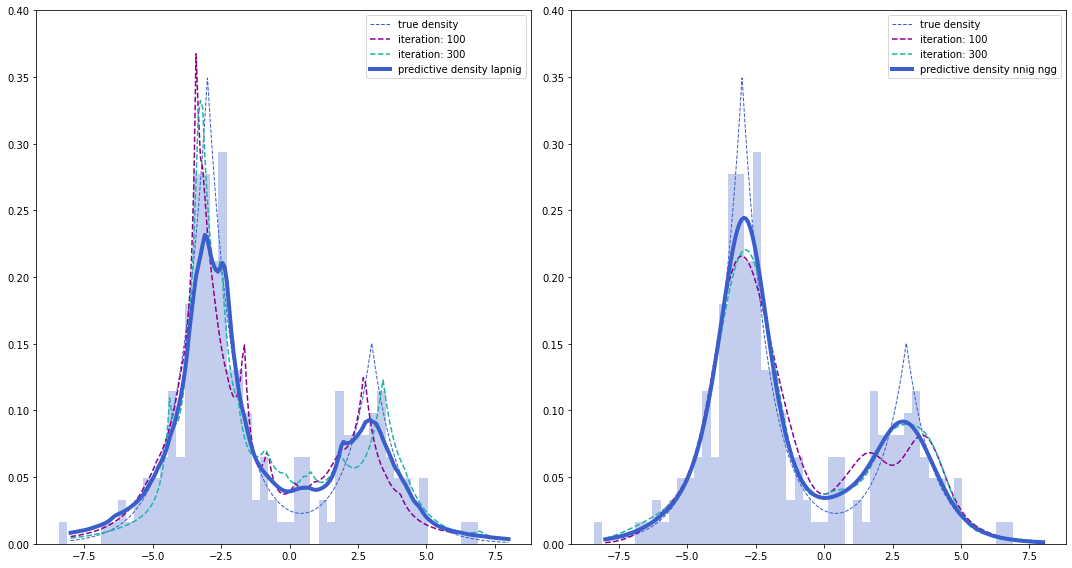

In [21]:
fig, axes = plt.subplots(1,2, figsize=(15,8))

axes[0].set_ylim(0, 0.4)
axes[1].set_ylim(0, 0.4)

axes[0].hist(y_lap, density=True, bins=50, alpha=0.3, color="#3A5FCD")
axes[0].plot(np.linspace(-8, 8, 1000), 0.7*ss.laplace.pdf(np.linspace(-8, 8, 1000), -3, 1) + 0.3*ss.laplace.pdf(np.linspace(-8, 8, 1000), 3, 1),
             "--", lw=1, color="#3A5FCD", label="true density")
axes[1].hist(y_lap, density=True, bins=50, alpha=0.3, color="#3A5FCD")
axes[1].plot(np.linspace(-8, 8, 1000), 0.7*ss.laplace.pdf(np.linspace(-8, 8, 1000), -3, 1) + 0.3*ss.laplace.pdf(np.linspace(-8, 8, 1000), 3, 1),
             "--", lw=1, color="#3A5FCD", label="true density")

idxs = [int((niter - nburn) * 0.25), int((niter - nburn) * 0.75)]
colors = ["#8B008B", "#20B2AA"]
for i, idx in enumerate(idxs):
    axes[0].plot(grid, densities_lapnig_2[idx, :], "--", label="iteration: {0}".format(idx), color = colors[i])
    axes[1].plot(grid, densities_nnig_ngg_2[idx, :], "--", label="iteration: {0}".format(idx), color = colors[i])
    
axes[0].plot(grid, np.mean(densities_lapnig_2, axis=0), lw=4, label="predictive density lapnig", color="#3A5FCD")
axes[1].plot(grid, np.mean(densities_nnig_ngg_2, axis=0), lw=4, label="predictive density nnig ngg", color="#3A5FCD")

axes[0].legend()
axes[1].legend()

axes[0].set_title("LapNIG density estimation on mixture of Laplace data")
axes[1].set_title("NNIG density estimation on mixture of Laplace data")

plt.tight_layout()
plt.show()